In [1]:
from dataviz import data_slice,data_timeplot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

# PROPHET MODEL for solving dynamic profile forecasting challenge

In [2]:
from fbprophet import Prophet
import numpy as np



ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [3]:

X_train=pd.read_csv('training_input_qFI2jug.csv', index_col="Horodate_UTC",parse_dates=['Horodate_UTC'],dayfirst=True)
feature_list=list(X_train.columns[3:])
#X_train['timestamp']=pd.to_datetime(X_train.index)
X_train.index = pd.DatetimeIndex(X_train.index)

liste_dates = X_train.index.tolist()
for dt in liste_dates :
    X_train.at[dt, 'sort'] = dt.strftime('%m%d%H%S')

X_train['sort'].astype(int)

df_month = X_train.sort_values(by='sort', ascending=True)
df_month.head(20)
df_month = df_month.interpolate(str="linear", axis=0).ffill().bfill()
df = df_month.sort_values(by='IDS', ascending=True)

X_train.drop('sort', axis=1)

X_train['Pseudo rayonnement'] = df['Pseudo rayonnement']
X_train['timestamp']=pd.to_datetime(X_train.index)

In [4]:
X_test=pd.read_csv('testing_input_BcjTmnd.csv',index_col="Horodate_UTC",parse_dates=['Horodate_UTC'],dayfirst=True)
#X_test['timestamp']=pd.to_datetime(X_test.index)
X_test.index = pd.DatetimeIndex(X_test.index)

X_test['timestamp']=pd.to_datetime(X_test.index)

In [5]:
y_train=pd.read_csv('training_output_uamzSZW.csv',index_col="Horodate_UTC",parse_dates=['Horodate_UTC'],dayfirst=True)
#y_train['timestamp']=pd.to_datetime(y_train.index)
y_train.index = pd.DatetimeIndex(y_train.index)

y_train['timestamp']=pd.to_datetime(y_train.index)

# dataset preparation for prophet interface

Prophet model requires a minimum of 2 columns matching the timeserie strucuture :
- column 'ds' contains the timestamp of the serie
- column 'y' contains the value of the serie
So the index of the original dataset y_train

In [6]:
# copy of y_train dataset with renaming of the 'RES1_BASE' column in 'y'
y_RES1_BASE=y_train.rename(columns={'RES1_BASE':'y'})
# creation of 'ds' column and copy of the initial dataset index
y_RES1_BASE['ds']=y_RES1_BASE.index


# Model evaluation over complete training period with default settings

In [7]:
# model creation and fitting over the trainin period till (30/04/2017)
prophet=Prophet()
prophet.fit(y_RES1_BASE.loc[:date(2017,4,30)])


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


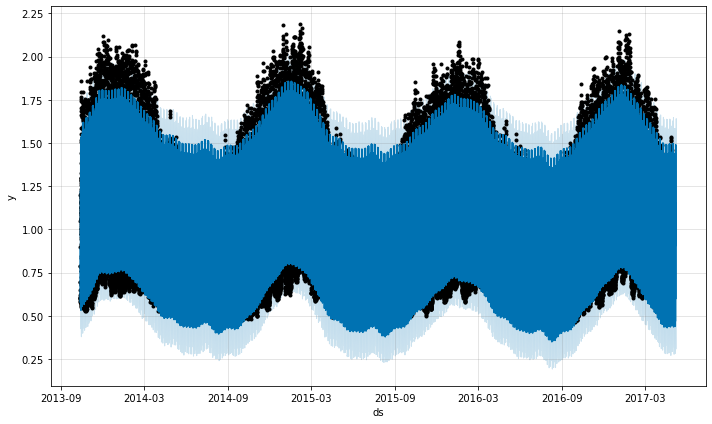

In [8]:
m=prophet
# creation of the future dataset that will include 7 day of forecast
# this 7 days period is passed to the by giving the frequence (30 minutes) and the number of samples 7*48
future = m.make_future_dataframe(periods=7*48, freq = '30T')
# creation of forecast dataset that will collect all the predcited value and the decomposition
forecast = m.predict(future)
fig = m.plot(forecast)

## results analysis
- resusults are stored in the forecast dataset wich contains severals columns as it is shown below
- 'yhat' contains $ \hat{y}$  the estimated values at the datetime index contained in 'ds'
- results are the plotted by extracting samples conatined in forecast dataset matching the period 7*48

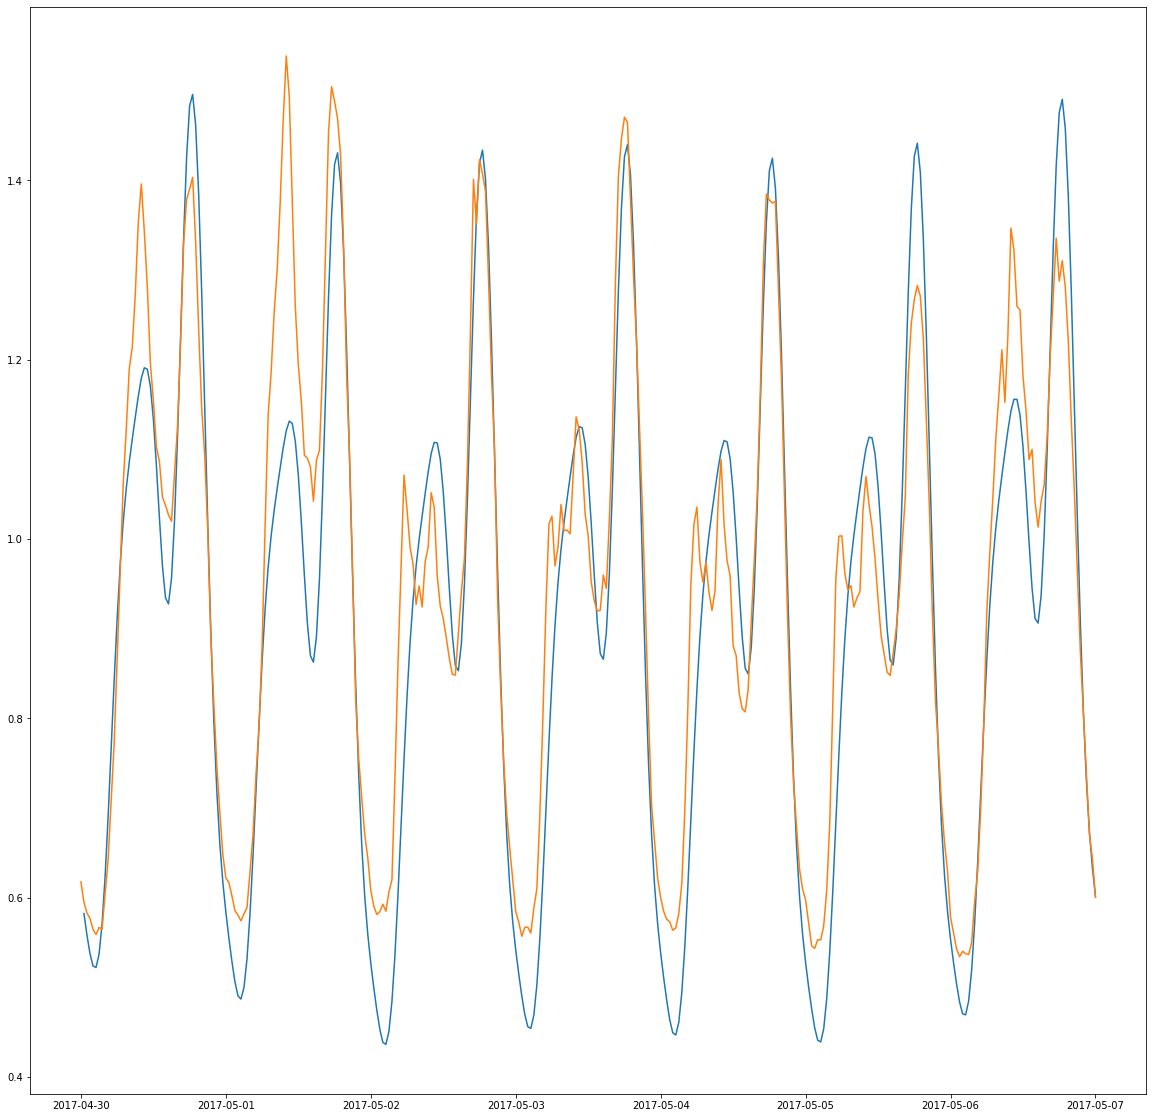

In [9]:
fig=plt.figure(figsize=(20,20))
id_max=forecast.shape[0]
# forecasted values ared stored at index contained in the index range [ id_max-(7*48+1) : id_max ]

plt.plot_date(forecast.iloc[id_max-7*48:id_max]['ds'],forecast.iloc[id_max-7*48:id_max]['yhat'],linestyle='-',marker=None)
plt.plot_date(y_train.loc[date(2017,4,30):date(2017,5,7)].index,y_train.loc[date(2017,4,30):date(2017,5,7)]['RES1_BASE'],linestyle='-',marker=None)
#plt.axvline(x=date(2017,4,30),color='green')

## Performance evaluation

In [10]:
from statsmodels.tools.eval_measures import rmse

Evaluation of the model with RMSE and MAPE metrics

In [11]:
# computation of metrics over the forecasted period using relative index from the end of the serie (id_max)
print('RMSE',rmse(forecast.iloc[id_max-(7*48+1):id_max]['yhat'],y_train.loc[date(2017,4,30):date(2017,5,7)]['RES1_BASE']))

print('MAPE %0.2f%%' % np.abs(100*(np.array(forecast.iloc[id_max-(7*48+1):id_max]['yhat'])-np.array(y_train.loc[date(2017,4,30):date(2017,5,7)]['RES1_BASE']))
                    /np.array(y_train.loc[date(2017,4,30):date(2017,5,7)]['RES1_BASE'])).mean())

RMSE 0.10888310755309405
MAPE 9.03%


# Introduction of seasonality

Following seasonality are introduced into the model

- working day / non  working day seasonality
- winter summer seasonality

A regressor is also added
- temperature regressor

In [12]:
#creation of the new dataset which contain new columns containing seasonality booleans
from seasons import seasonalize
arguments = {'mixed_columns': True, 'merge': True, 'pentecote': False, 'extradayoff': True, 
             'events' : {'world_cup_2014': ['12/06/2014', '13/07/2014'], 'rentree_2014': '02/09/2014', 'rentree_2015': '01/09/2015', 
                         'euro_cup_2016': ['10/06/2016', '10/07/2016'], 'rentree_2016': '01/09/2016', 'rentree_2017': '04/09/2017', 
                         'rentree_2018': '03/09/2018', 'world_cup_2018': ['14/06/2018', '15/07/2018']}}

df = seasonalize(y_RES1_BASE.loc[:date(2017,4,30)], **arguments).seasons_dataset()
df.special_days = df.special_days.astype(int)

In [13]:
df.tail()

,special_days,offpeak_hours,IDS,Horodate,Mois,y,RES11_BASE,PRO1_BASE,RES2_HC,RES2_HP,PRO2_HC,PRO2_HP,timestamp,ds,winter_on_work,winter_off_work,summer_on_work,summer_off_work
Horodate_UTC,,,,,,,,,,,,,,,,,,
2017-04-29 22:00:00,0,1,62113,2017-04-29T00:00:00+02:00,4,0.814663,0.840376,0.684982,2.972425,0.341289,2.371354,0.284084,2017-04-29 22:00:00,2017-04-29 22:00:00,False,False,False,True
2017-04-29 22:30:00,0,1,62114,2017-04-29T00:30:00+02:00,4,0.752960,0.766005,0.672847,2.536995,0.337800,2.269945,0.275379,2017-04-29 22:30:00,2017-04-29 22:30:00,False,False,False,True
2017-04-29 23:00:00,0,1,62115,2017-04-29T01:00:00+02:00,4,0.697842,0.743610,0.662718,2.571302,0.242539,2.375219,0.200730,2017-04-29 23:00:00,2017-04-29 23:00:00,False,False,False,True
2017-04-29 23:30:00,0,1,62116,2017-04-29T01:30:00+02:00,4,0.647291,0.727882,0.664021,2.689254,0.168847,2.586478,0.132686,2017-04-29 23:30:00,2017-04-29 23:30:00,False,False,False,True
2017-04-30 00:00:00,0,1,62117,2017-04-29T02:00:00+02:00,4,0.617449,0.698508,0.657001,2.764839,0.059525,2.711891,0.051934,2017-04-30 00:00:00,2017-04-30 00:00:00,False,False,False,True


## Regressor is added to the dataset

In [14]:
# copy of the temperature (columns 18 from X_train) is added to the dataset in column 'temp'
df['temp'] = X_train.iloc[0:,19:20]

df.head()

,special_days,offpeak_hours,IDS,Horodate,Mois,y,RES11_BASE,PRO1_BASE,RES2_HC,RES2_HP,PRO2_HC,PRO2_HP,timestamp,ds,winter_on_work,winter_off_work,summer_on_work,summer_off_work,temp
Horodate_UTC,,,,,,,,,,,,,,,,,,,
2013-10-13 22:00:00,0,1,1,2013-10-13T00:00:00+02:00,10,0.791405,0.698925,NaN,2.780413,0.346364,NaN,NaN,2013-10-13 22:00:00,2013-10-13 22:00:00,False,False,False,True,13.5
2013-10-13 22:30:00,0,1,2,2013-10-13T00:30:00+02:00,10,0.693700,0.722778,NaN,2.301527,0.375439,NaN,NaN,2013-10-13 22:30:00,2013-10-13 22:30:00,False,False,False,True,13.5
2013-10-13 23:00:00,0,1,3,2013-10-13T01:00:00+02:00,10,0.648565,0.678717,NaN,2.361320,0.268125,NaN,NaN,2013-10-13 23:00:00,2013-10-13 23:00:00,False,False,False,True,13.5
2013-10-13 23:30:00,0,1,4,2013-10-13T01:30:00+02:00,10,0.621059,0.668509,NaN,2.567490,0.192953,NaN,NaN,2013-10-13 23:30:00,2013-10-13 23:30:00,False,False,False,True,13.5
2013-10-14 00:00:00,0,1,5,2013-10-13T02:00:00+02:00,10,0.612245,0.700487,NaN,2.563460,0.075701,NaN,NaN,2013-10-14 00:00:00,2013-10-14 00:00:00,False,False,True,False,13.5


In [15]:
def weather_temp(df):
    columns = list(X_train.columns.values.tolist()) 
    if isinstance(df.index, pd.DatetimeIndex):
        list_date = df.index.tolist()
        count = 0
        for d in list_date:
            df.at[d, 'temp'] = X_train.loc[d,columns[19]]
            count = count + 1
    return df

## Creation of the Prophet model with custom seasonality an regressor
internal daily seasonality is desactivated

In [16]:
m = Prophet(daily_seasonality=False)

m.add_seasonality(name='winter_on_work', period=1, fourier_order=12, condition_name='winter_on_work')
m.add_seasonality(name='winter_off_work', period=1, fourier_order=12, condition_name='winter_off_work')
m.add_seasonality(name='summer_on_work', period=1, fourier_order=12, condition_name='summer_on_work')
m.add_seasonality(name='summer_off_work', period=1, fourier_order=12, condition_name='summer_off_work')

m.add_regressor(name='temp')
m.add_regressor(name='special_days')
# m.add_regressor(name='offpeak_hours')

Model training

In [17]:
m.fit(df)


### Preparation of future dataset for the forecast
creation of the seasonality and regressors columns

In [18]:
future = m.make_future_dataframe(periods=7*48, freq = '30T')

future['id']=future.index
future.index=future['ds']

future=seasonalize(future, **arguments).seasons_dataset()
future.special_days = future.special_days.astype(int)

future = weather_temp(future)
future.head()

# calendar.Dataframe(future)
# future=calendar.prophet_days_onoff()
future.index=future['id']
future=future.drop(["id"],axis=1)
future.head()

,special_days,offpeak_hours,ds,winter_on_work,winter_off_work,summer_on_work,summer_off_work,temp
id,,,,,,,,
0,0,1,2013-10-13 22:00:00,False,False,False,True,13.5
1,0,1,2013-10-13 22:30:00,False,False,False,True,13.5
2,0,1,2013-10-13 23:00:00,False,False,False,True,13.5
3,0,1,2013-10-13 23:30:00,False,False,False,True,13.5
4,0,1,2013-10-14 00:00:00,False,False,True,False,13.5


## Forecast calculation
results are the plotted :
- components of the forecast :  trend, yealry seasonality, weekly seasonality, daily custom sesonality, regressor
- forecasted serie

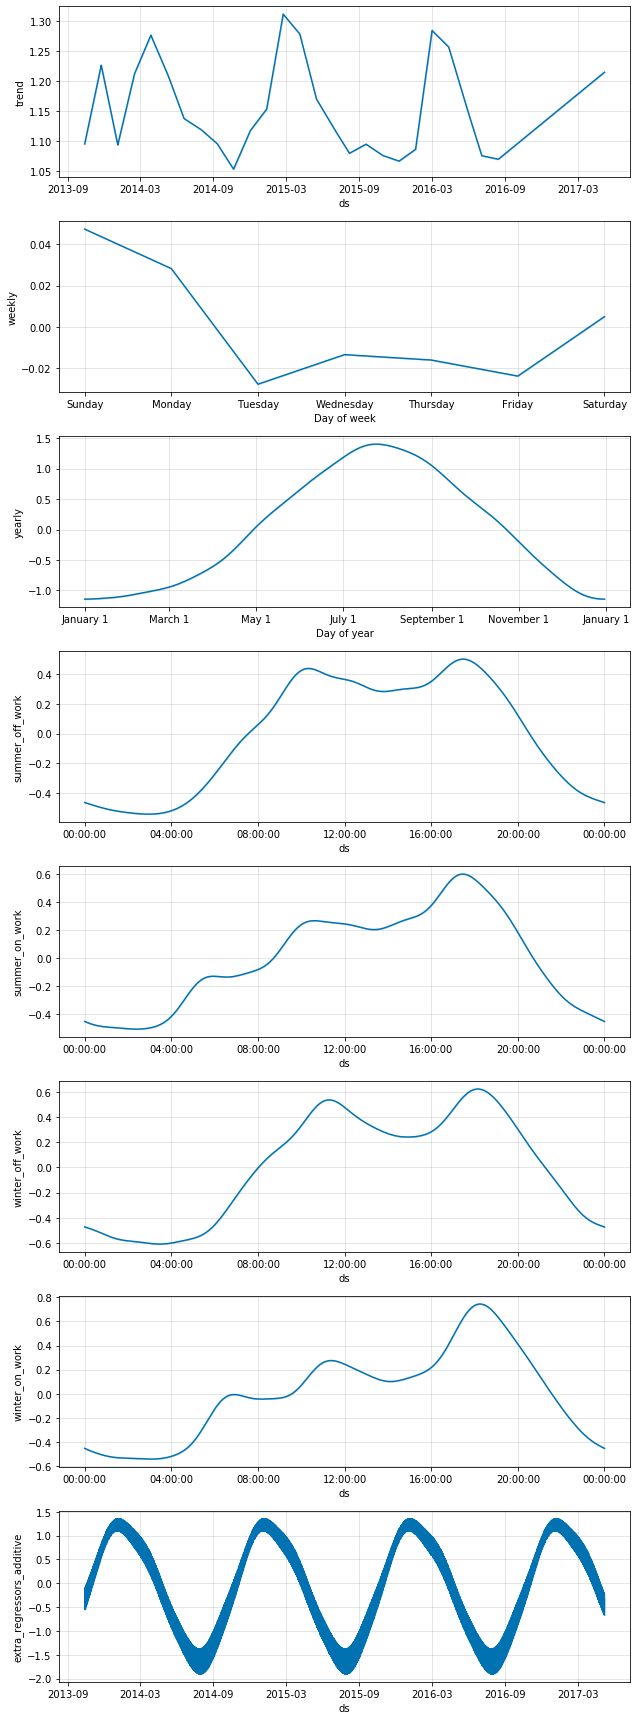

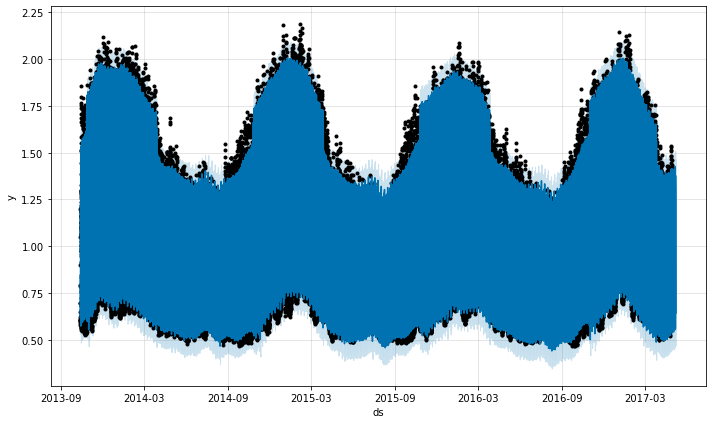

In [19]:

forecast = m.predict(future)

fig = m.plot_components(forecast)

fig = m.plot(forecast)

# Focus on the forecast and model evaluation

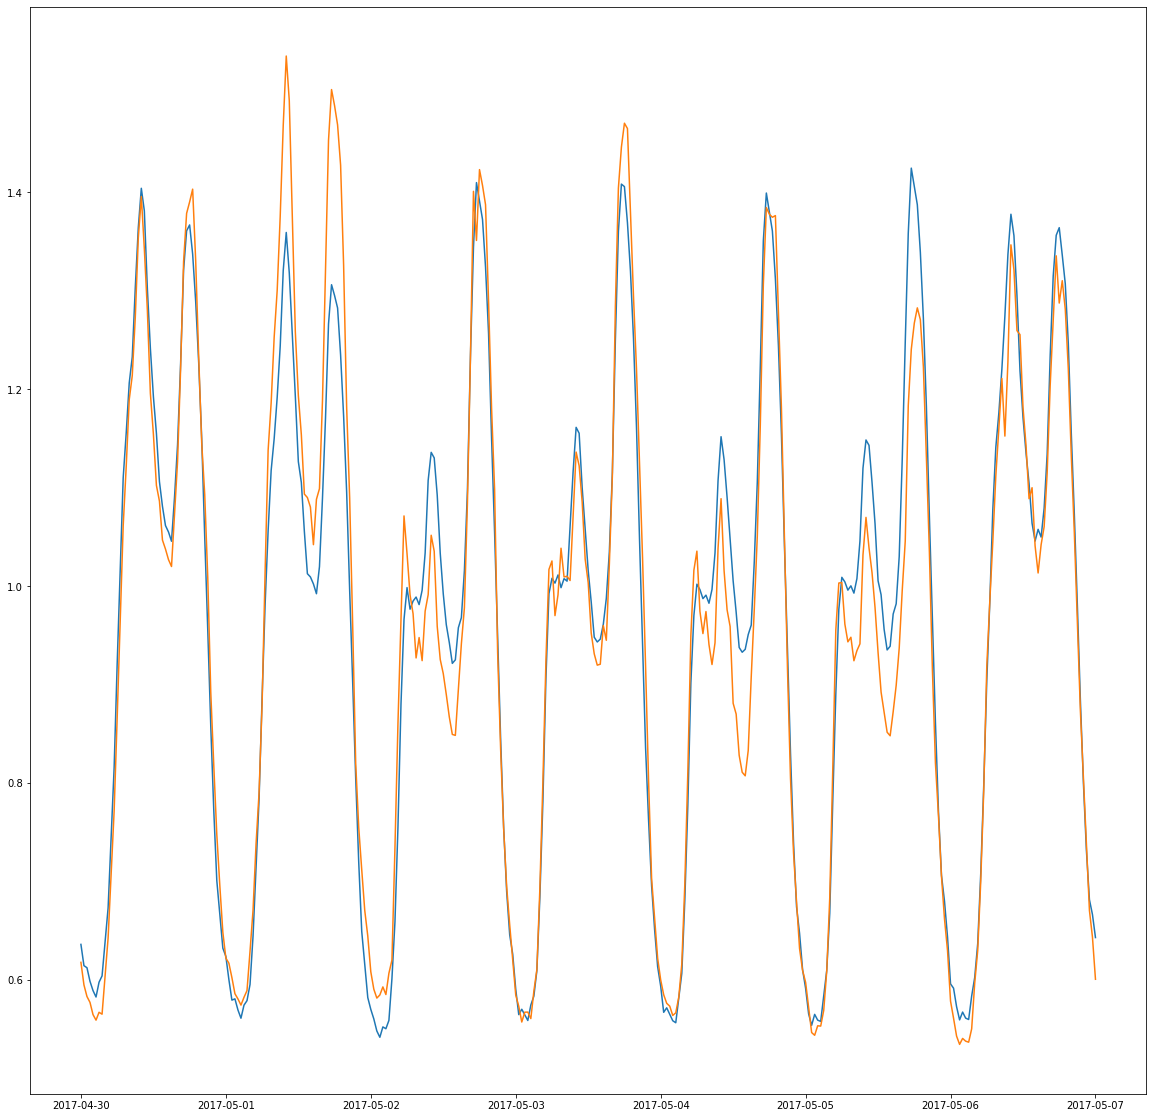

In [20]:
fig=plt.figure(figsize=(20,20))
id_max=forecast.shape[0]
plt.plot_date(forecast.iloc[id_max-(7*48+1):id_max]['ds'],forecast.iloc[id_max-(7*48+1):id_max]['yhat'],linestyle='-',marker=None)
plt.plot_date(y_train.loc[date(2017,4,30):date(2017,5,7)].index,y_train.loc[date(2017,4,30):date(2017,5,7)]['RES1_BASE'],linestyle='-',marker=None)

In [21]:
print('RMSE',rmse(forecast.iloc[id_max-(7*48+1):id_max]['yhat'],y_train.loc[date(2016,4,30):date(2016,5,7)]['RES1_BASE']))

print('MAPE %0.2f%%' % np.abs(100*(np.array(forecast.iloc[id_max-(7*48+1):id_max]['yhat'])-np.array(y_train.loc[date(2017,4,30):date(2017,5,7)]['RES1_BASE']))
                    /np.array(y_train.loc[date(2017,4,30):date(2017,5,7)]['RES1_BASE'])).mean())

RMSE 0.0954984659992823
MAPE 4.63%


# Comparison of forecasted and real daily profiles

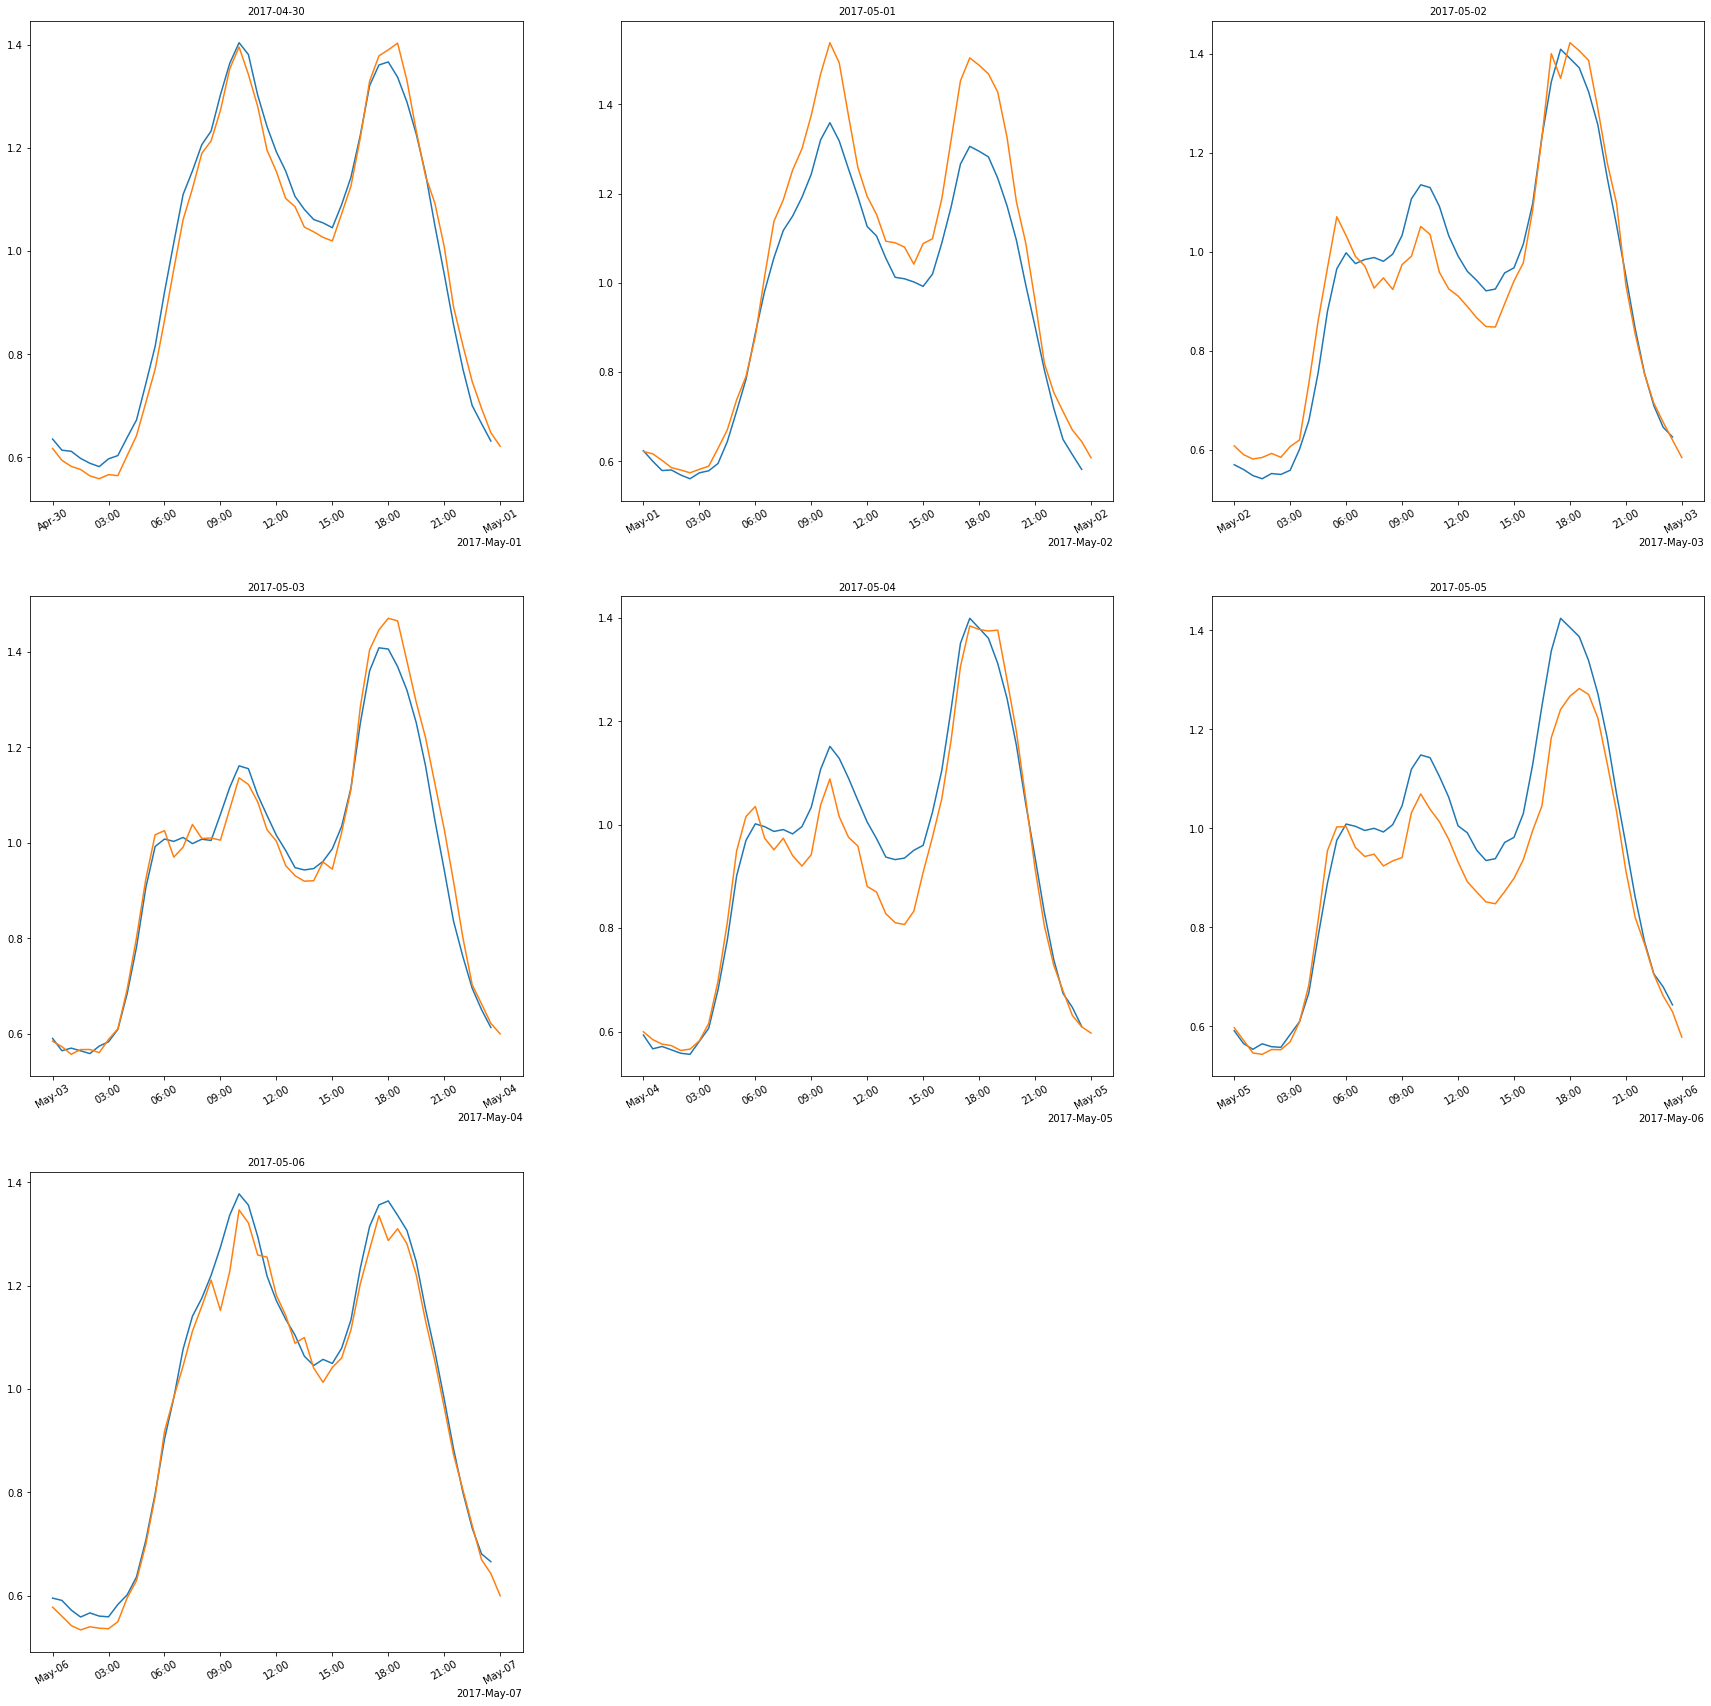

In [22]:
import pytz
from matplotlib.dates import (HourLocator, AutoDateLocator, DateFormatter,
                              ConciseDateFormatter, rrulewrapper, RRuleLocator, drange)


paris=pytz.timezone('Europe/Paris')
locator = AutoDateLocator()
formatter=ConciseDateFormatter(locator,tz=paris)


fig=plt.figure(figsize=(30,30)) 
for i in range(7) :
        
        ax=fig.add_subplot(3,3,i+1)
        ax.plot_date(forecast.iloc[id_max-((7-i)*48+1):id_max-((6-i)*48+1)]['ds'],forecast.iloc[id_max-((7-i)*48+1):id_max-((6-i)*48+1)]['yhat'],linestyle='-',marker=None);
        ax.plot_date(y_train.loc[date(2017,4,30)+48*i*pd.Timedelta('30m'):date(2017,4,30)+48*(i+1)*pd.Timedelta('30m')].index,
                     y_train.loc[date(2017,4,30)+48*i*pd.Timedelta('30m'):date(2017,4,30)+48*(i+1)*pd.Timedelta('30m')]['RES1_BASE'],linestyle='-',marker=None)
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_tick_params(rotation=30, labelsize=10)
        ax.set_title(date(2017,4,30)+48*i*pd.Timedelta('30m'),fontsize=10)

In [23]:
df.tail()

,special_days,offpeak_hours,IDS,Horodate,Mois,y,RES11_BASE,PRO1_BASE,RES2_HC,RES2_HP,PRO2_HC,PRO2_HP,timestamp,ds,winter_on_work,winter_off_work,summer_on_work,summer_off_work,temp
Horodate_UTC,,,,,,,,,,,,,,,,,,,
2017-04-29 22:00:00,0,1,62113,2017-04-29T00:00:00+02:00,4,0.814663,0.840376,0.684982,2.972425,0.341289,2.371354,0.284084,2017-04-29 22:00:00,2017-04-29 22:00:00,False,False,False,True,13.4
2017-04-29 22:30:00,0,1,62114,2017-04-29T00:30:00+02:00,4,0.752960,0.766005,0.672847,2.536995,0.337800,2.269945,0.275379,2017-04-29 22:30:00,2017-04-29 22:30:00,False,False,False,True,13.4
2017-04-29 23:00:00,0,1,62115,2017-04-29T01:00:00+02:00,4,0.697842,0.743610,0.662718,2.571302,0.242539,2.375219,0.200730,2017-04-29 23:00:00,2017-04-29 23:00:00,False,False,False,True,13.4
2017-04-29 23:30:00,0,1,62116,2017-04-29T01:30:00+02:00,4,0.647291,0.727882,0.664021,2.689254,0.168847,2.586478,0.132686,2017-04-29 23:30:00,2017-04-29 23:30:00,False,False,False,True,13.4
2017-04-30 00:00:00,0,1,62117,2017-04-29T02:00:00+02:00,4,0.617449,0.698508,0.657001,2.764839,0.059525,2.711891,0.051934,2017-04-30 00:00:00,2017-04-30 00:00:00,False,False,False,True,13.3


## Regressor is added to the dataset

In [24]:
# copy of the temperature (columns 18 from X_train) is added to the dataset in column 'temp'
df['temp'] = X_train.iloc[0:,18:19]

df.head()

,special_days,offpeak_hours,IDS,Horodate,Mois,y,RES11_BASE,PRO1_BASE,RES2_HC,RES2_HP,PRO2_HC,PRO2_HP,timestamp,ds,winter_on_work,winter_off_work,summer_on_work,summer_off_work,temp
Horodate_UTC,,,,,,,,,,,,,,,,,,,
2013-10-13 22:00:00,0,1,1,2013-10-13T00:00:00+02:00,10,0.791405,0.698925,NaN,2.780413,0.346364,NaN,NaN,2013-10-13 22:00:00,2013-10-13 22:00:00,False,False,False,True,9.6
2013-10-13 22:30:00,0,1,2,2013-10-13T00:30:00+02:00,10,0.693700,0.722778,NaN,2.301527,0.375439,NaN,NaN,2013-10-13 22:30:00,2013-10-13 22:30:00,False,False,False,True,9.6
2013-10-13 23:00:00,0,1,3,2013-10-13T01:00:00+02:00,10,0.648565,0.678717,NaN,2.361320,0.268125,NaN,NaN,2013-10-13 23:00:00,2013-10-13 23:00:00,False,False,False,True,9.6
2013-10-13 23:30:00,0,1,4,2013-10-13T01:30:00+02:00,10,0.621059,0.668509,NaN,2.567490,0.192953,NaN,NaN,2013-10-13 23:30:00,2013-10-13 23:30:00,False,False,False,True,9.5
2013-10-14 00:00:00,0,1,5,2013-10-13T02:00:00+02:00,10,0.612245,0.700487,NaN,2.563460,0.075701,NaN,NaN,2013-10-14 00:00:00,2013-10-14 00:00:00,False,False,True,False,9.5


In [25]:
def weather_temp(df):
    columns = list(X_train.columns.values.tolist()) 
    if isinstance(df.index, pd.DatetimeIndex):
        list_date = df.index.tolist()
        count = 0
        for d in list_date:
            df.at[d, 'temp'] = X_train.loc[d,columns[18]]
            count = count + 1
    return df

## Creation of the Prophet model with custom seasonality an regressor
internal daily seasonality is desactivated

In [26]:
m = Prophet(daily_seasonality=False)

m.add_seasonality(name='winter_on_work', period=1, fourier_order=12, condition_name='winter_on_work')
m.add_seasonality(name='winter_off_work', period=1, fourier_order=12, condition_name='winter_off_work')
m.add_seasonality(name='summer_on_work', period=1, fourier_order=12, condition_name='summer_on_work')
m.add_seasonality(name='summer_off_work', period=1, fourier_order=12, condition_name='summer_off_work')

m.add_regressor(name='temp')
m.add_regressor(name='special_days')
# m.add_regressor(name='offpeak_hours')


Model training

In [27]:
m.fit(df)


### Preparation of future dataset for the forecast
creation of the seasonality and regressors columns

In [28]:
future = m.make_future_dataframe(periods=7*48, freq = '30T')

future['id']=future.index
future.index=future['ds']

future=seasonalize(future, **arguments).seasons_dataset()
future.special_days = future.special_days.astype(int)

future = weather_temp(future)
future.head()

# calendar.Dataframe(future)
# future=calendar.prophet_days_onoff()
future.index=future['id']
future=future.drop(["id"],axis=1)
future.head()

,special_days,offpeak_hours,ds,winter_on_work,winter_off_work,summer_on_work,summer_off_work,temp
id,,,,,,,,
0,0,1,2013-10-13 22:00:00,False,False,False,True,9.6
1,0,1,2013-10-13 22:30:00,False,False,False,True,9.6
2,0,1,2013-10-13 23:00:00,False,False,False,True,9.6
3,0,1,2013-10-13 23:30:00,False,False,False,True,9.5
4,0,1,2013-10-14 00:00:00,False,False,True,False,9.5


## Forecast calculation
results are the plotted :
- components of the forecast :  trend, yealry seasonality, weekly seasonality, daily custom sesonality, regressor
- forecasted serie

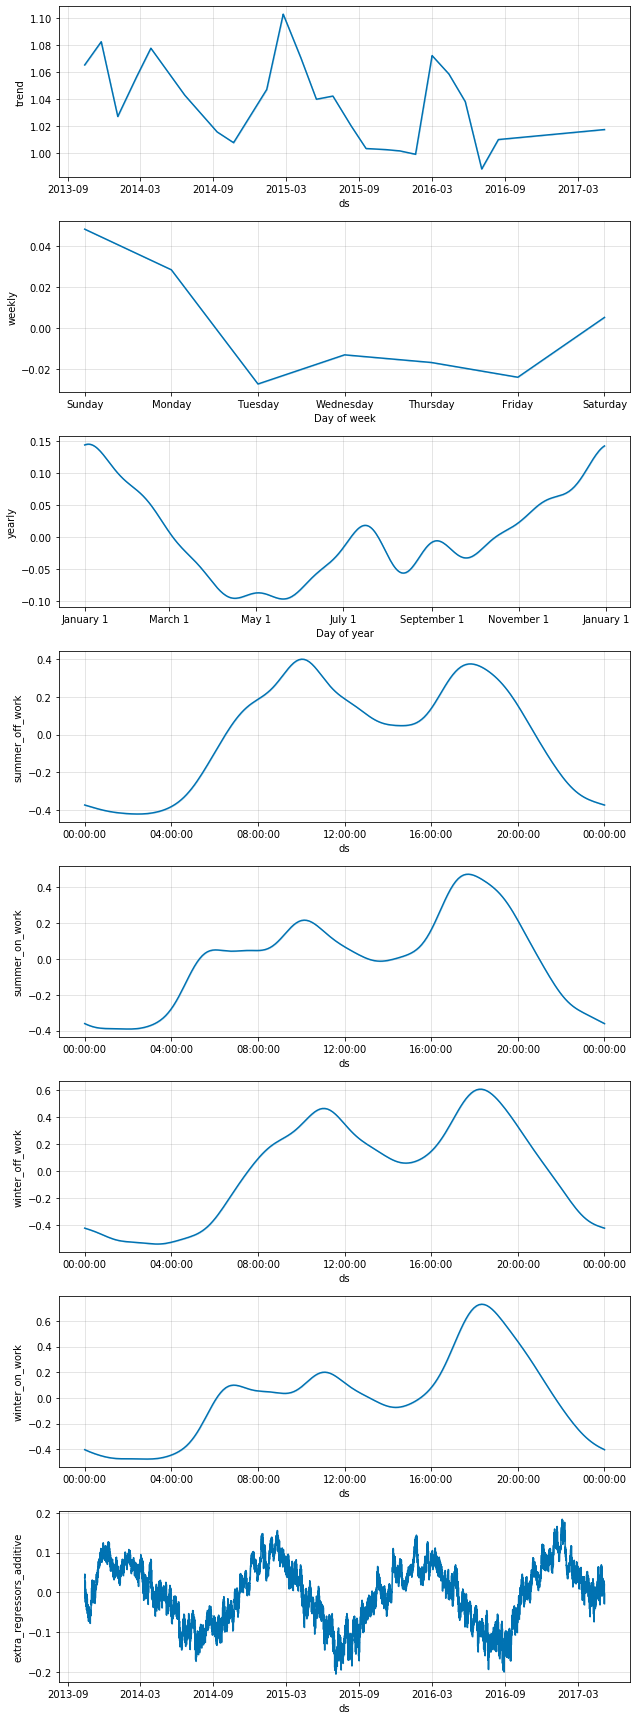

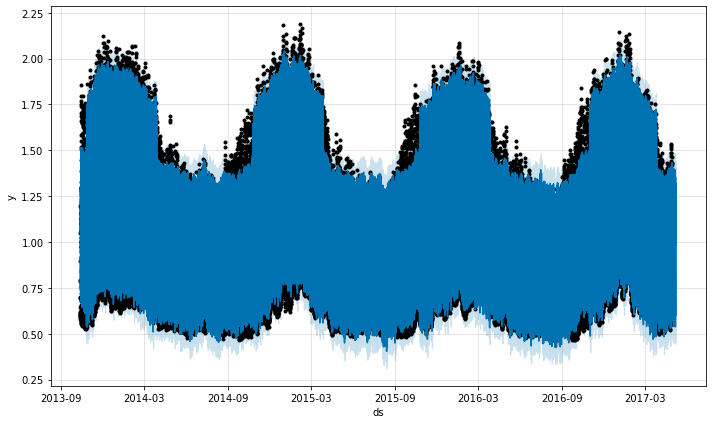

In [29]:

forecast = m.predict(future)

fig = m.plot_components(forecast)

fig = m.plot(forecast)

# Focus on the forecast and model evaluation

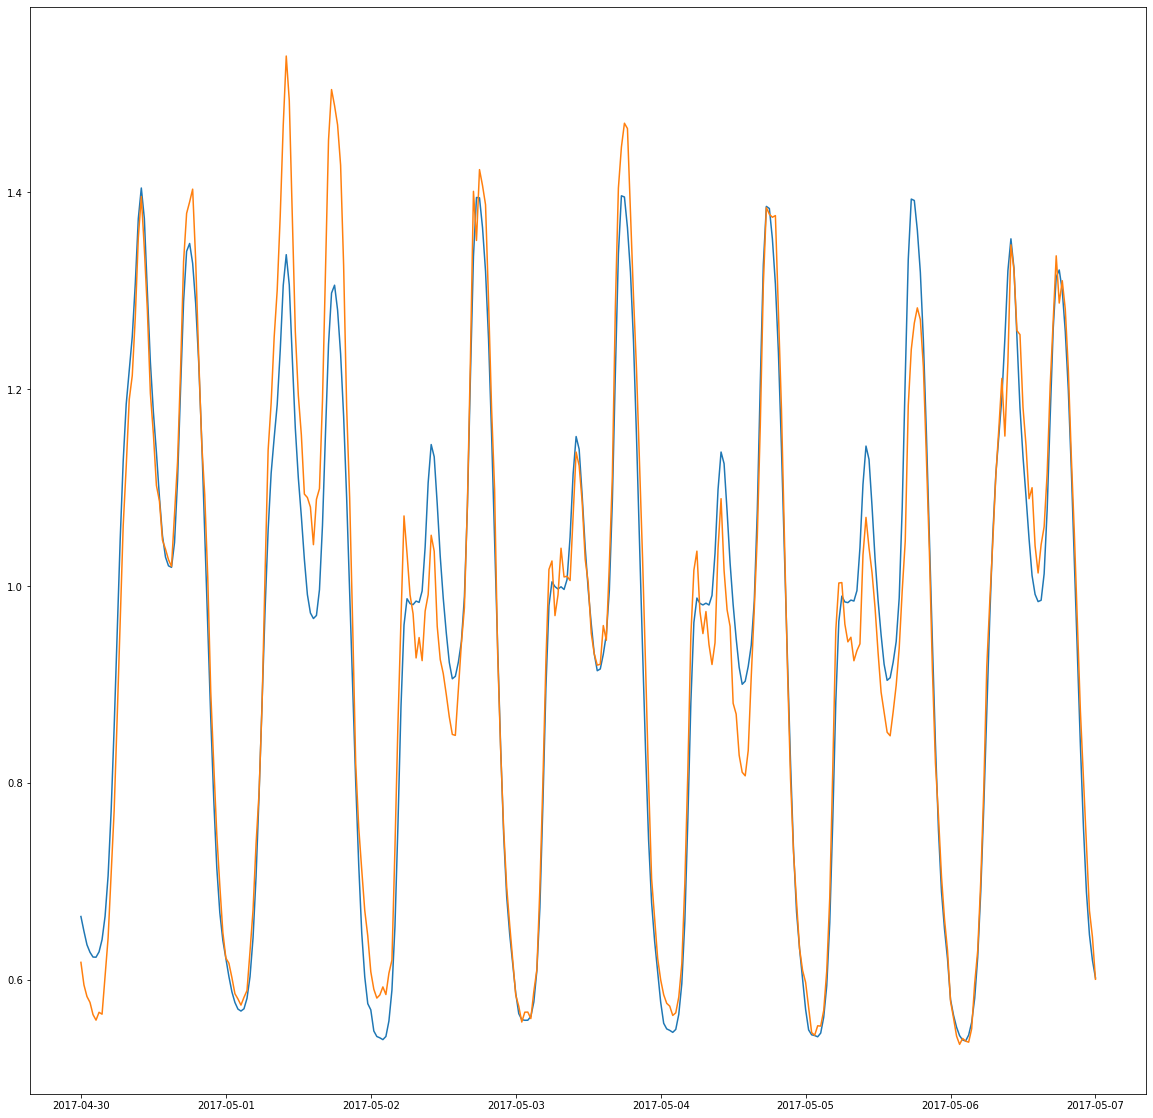

In [30]:
fig=plt.figure(figsize=(20,20))
id_max=forecast.shape[0]
plt.plot_date(forecast.iloc[id_max-(7*48+1):id_max]['ds'],forecast.iloc[id_max-(7*48+1):id_max]['yhat'],linestyle='-',marker=None)
plt.plot_date(y_train.loc[date(2017,4,30):date(2017,5,7)].index,y_train.loc[date(2017,4,30):date(2017,5,7)]['RES1_BASE'],linestyle='-',marker=None)

In [31]:
print('RMSE',rmse(forecast.iloc[id_max-(7*48+1):id_max]['yhat'],y_train.loc[date(2016,4,30):date(2016,5,7)]['RES1_BASE']))

print('MAPE %0.2f%%' % np.abs(100*(np.array(forecast.iloc[id_max-(7*48+1):id_max]['yhat'])-np.array(y_train.loc[date(2017,4,30):date(2017,5,7)]['RES1_BASE']))
                    /np.array(y_train.loc[date(2017,4,30):date(2017,5,7)]['RES1_BASE'])).mean())

RMSE 0.0886676178075896
MAPE 4.65%


# Comparison of forecasted and real daily profiles

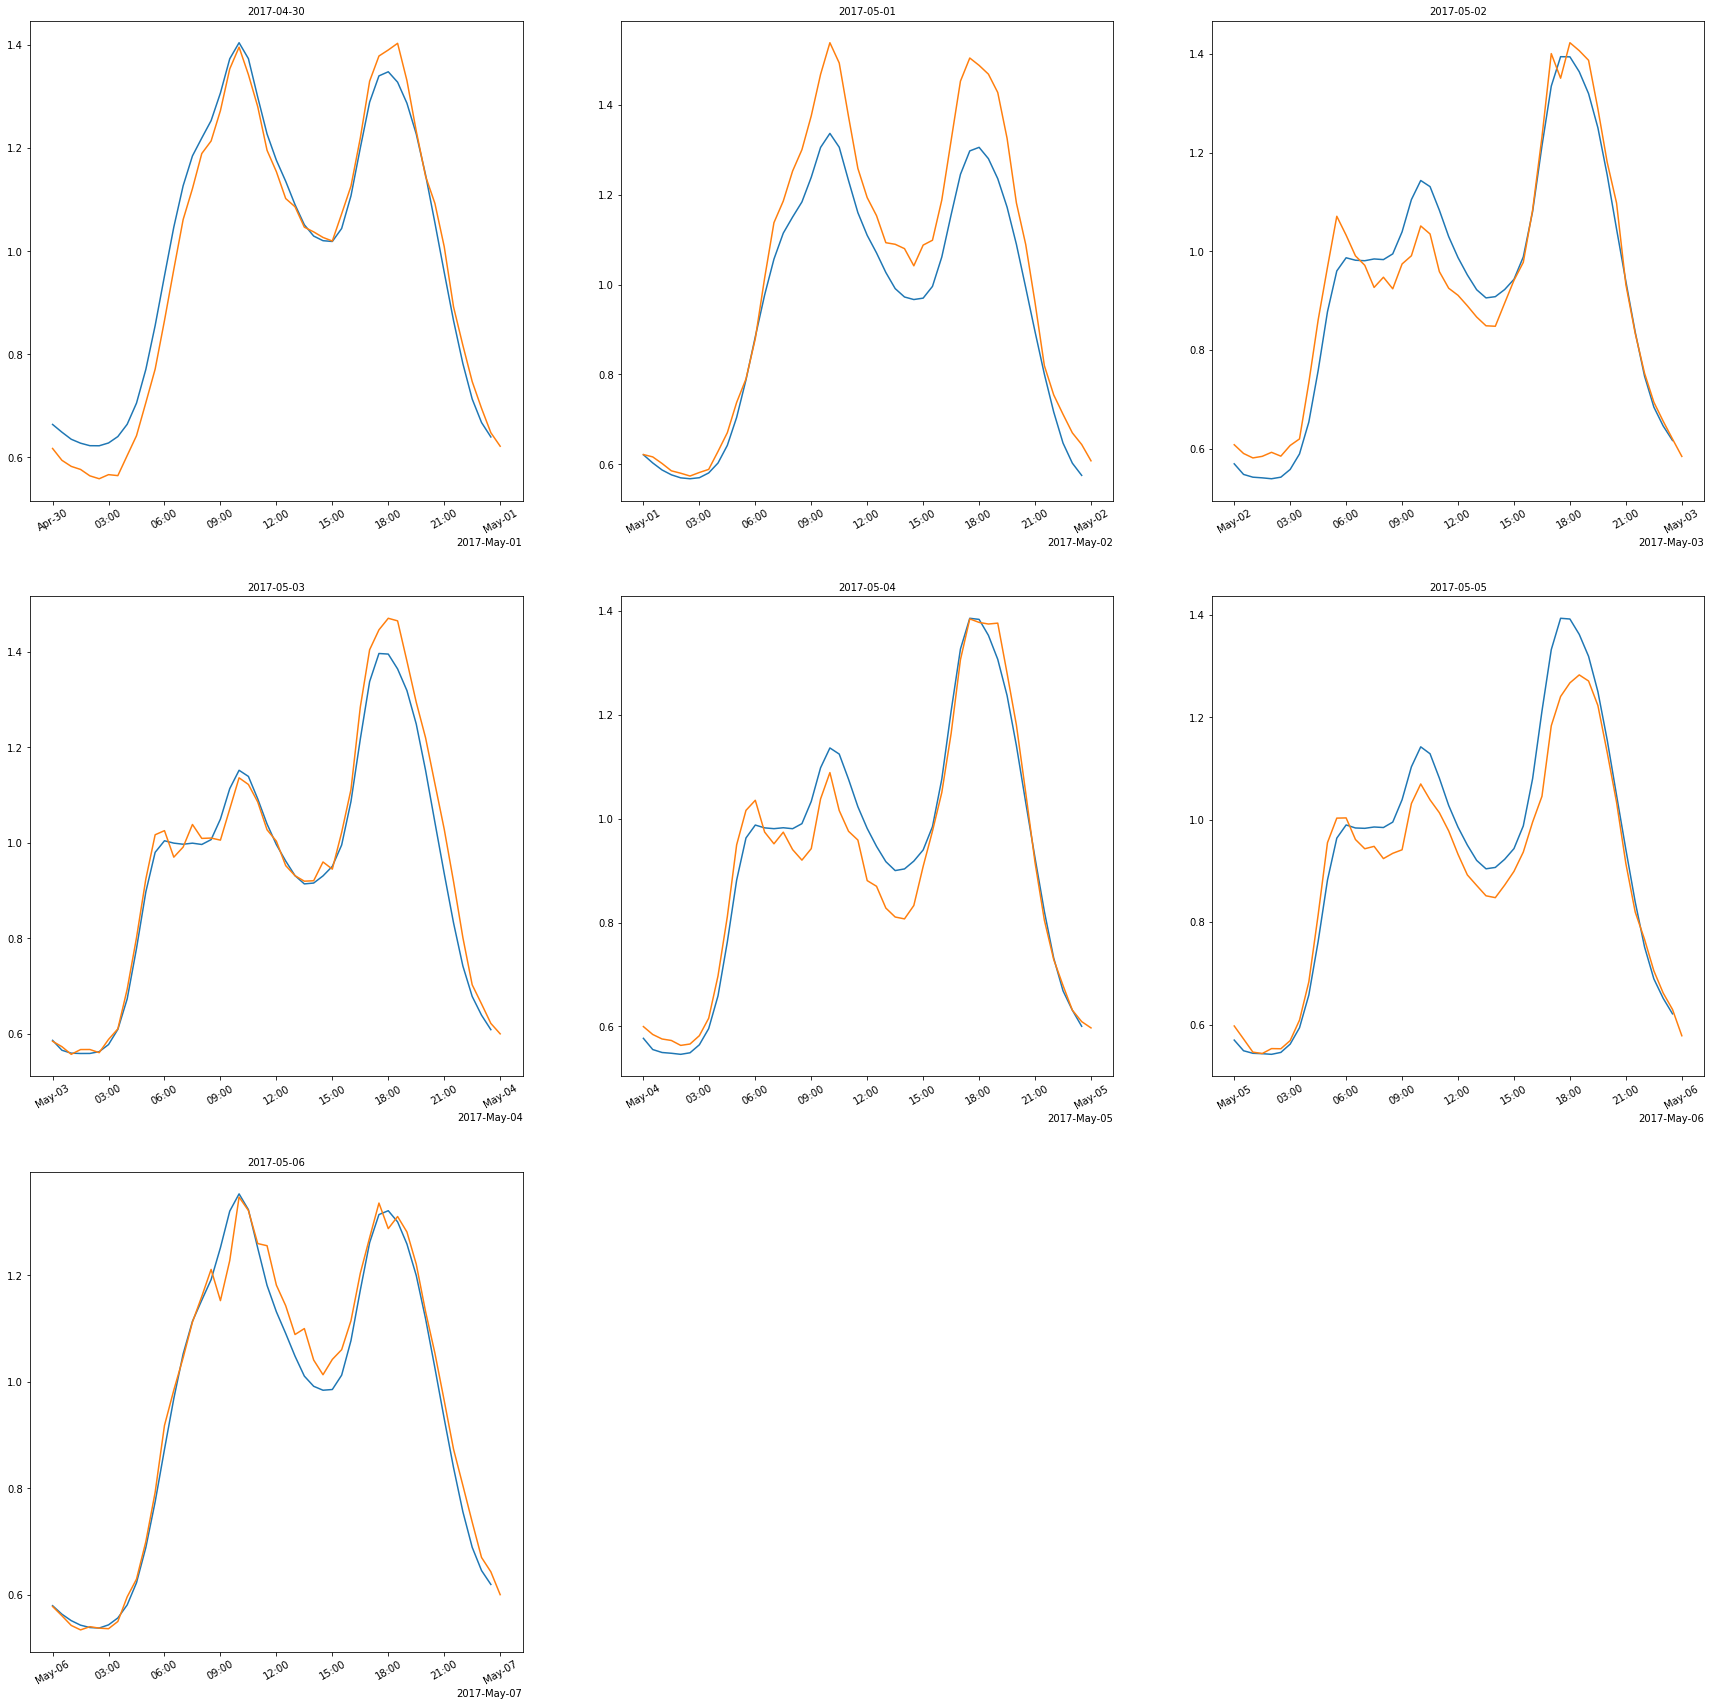

In [32]:
import pytz
from matplotlib.dates import (HourLocator, AutoDateLocator, DateFormatter,
                              ConciseDateFormatter, rrulewrapper, RRuleLocator, drange)


paris=pytz.timezone('Europe/Paris')
locator = AutoDateLocator()
formatter=ConciseDateFormatter(locator,tz=paris)


fig=plt.figure(figsize=(30,30)) 
for i in range(7) :
        
        ax=fig.add_subplot(3,3,i+1)
        ax.plot_date(forecast.iloc[id_max-((7-i)*48+1):id_max-((6-i)*48+1)]['ds'],forecast.iloc[id_max-((7-i)*48+1):id_max-((6-i)*48+1)]['yhat'],linestyle='-',marker=None);
        ax.plot_date(y_train.loc[date(2017,4,30)+48*i*pd.Timedelta('30m'):date(2017,4,30)+48*(i+1)*pd.Timedelta('30m')].index,
                     y_train.loc[date(2017,4,30)+48*i*pd.Timedelta('30m'):date(2017,4,30)+48*(i+1)*pd.Timedelta('30m')]['RES1_BASE'],linestyle='-',marker=None)
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_tick_params(rotation=30, labelsize=10)
        ax.set_title(date(2017,4,30)+48*i*pd.Timedelta('30m'),fontsize=10)